In [1]:
import numpy as np  # this module handles arrays, but here we need it for its NaN value
import pandas as pd # this module contains a lot of tools for handling tabular data
from matplotlib import pyplot as plt
from salishsea_tools import evaltools as et
import datetime as dt
import os
import gsw
import pickle
import netCDF4 as nc
import cmocean
from scipy import stats as spst
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

In [2]:
modSourceDir= '/results/SalishSea/nowcast-green.201812/'
modver='201812'
Chl_N=1.8 # Chl:N ratio
fname='compHPLCModelFirstLook-Regress-Base.ipynb'
startYMD=(2015,1,1)
endYMD=(2018,12,31)

In [3]:
# Parameters
modSourceDir = '/data/eolson/results/MEOPAR/SS36runs/GrahamRuns/2018ES_LF/'
modver = '2018ES_LF'
start_date = dt.datetime(2017,1,1)
end_date = dt.datetime(2017, 6, 30)
Chl_N = 1.8
#fname = "compHPLCModelFirstLook-Regress-2018ES_LF-2015.ipynb"


In [4]:
datestr='_'+start_date.strftime('%Y%m%d')+'_'+end_date.strftime('%Y%m%d')

In [5]:
def subval(idf,colList):
    # first value in colList should be the column you are going to keep
    # follow with other columns that will be used to fill in when that column is NaN
    # in order of precedence
    if len(colList)==2:
        idf[colList[0]]=[r[colList[0]] if not pd.isna(r[colList[0]]) \
                         else  r[colList[1]] for i,r in idf.iterrows()]
    elif len(colList)==3:
        idf[colList[0]]=[r[colList[0]] if not pd.isna(r[colList[0]]) \
                         else  r[colList[1]] if not pd.isna(r[colList[1]]) \
                         else r[colList[2]] for i,r in idf.iterrows()]
    else:
        raise NotImplementedError('Add to code to handle this case')
    idf.drop(columns=list(colList[1:]),inplace=True)
    return idf

In [6]:
if os.path.isfile('matched_'+modver+datestr+'.pkl'):
    data=pickle.load(open( 'matched_'+modver+datestr+'.pkl', 'rb' ) )
else:
    # define paths to the source files and eventual output file
    flist=('/ocean/eolson/MEOPAR/obs/NemcekHPLC/bottlePhytoMerged2015.csv',
           '/ocean/eolson/MEOPAR/obs/NemcekHPLC/bottlePhytoMerged2016.csv',
           '/ocean/eolson/MEOPAR/obs/NemcekHPLC/bottlePhytoMerged2017.csv',
           '/ocean/eolson/MEOPAR/obs/NemcekHPLC/bottlePhytoMerged2018.csv')#,
           #'/ocean/eolson/MEOPAR/obs/NemcekHPLC/bottlePhytoMerged2019.csv')

    dfs=list()
    for fname in flist:
        idf=pd.read_csv(fname)
        print(fname,sorted(idf.keys()))
        dfs.append(idf)
    df=pd.concat(dfs,ignore_index=True,sort=False); # concatenate the list into a single table

    df.drop(labels=['ADM:MISSION','ADM:PROJECT','ADM:SCIENTIST','Zone','Zone.1','Temperature:Draw',
                    'Temperature:Draw [deg C (ITS90)]','Bottle:Firing_Sequence','Comments by sample_numbeR',
                    'File Name','LOC:EVENT_NUMBER','Number_of_bin_records'
                       ],axis=1,inplace=True)

    df=subval(df,('Dictyochophytes','Dictyo'))
    df=subval(df,('Chlorophyll:Extracted [mg/m^3]','Chlorophyll:Extracted'))
    df=subval(df,('Dinoflagellates','Dinoflagellates-1'))
    df=subval(df,('Fluorescence [mg/m^3]','Fluorescence:URU:Seapoint [mg/m^3]','Fluorescence:URU:Seapoint'))
    df=subval(df,('Lat','LOC:LATITUDE'))
    df=subval(df,('Lon','LOC:LONGITUDE'))
    df=subval(df,('Nitrate_plus_Nitrite [umol/L]','Nitrate_plus_Nitrite'))
    df=subval(df,('PAR [uE/m^2/sec]','PAR'))
    df=subval(df,('Phaeo-Pigment:Extracted [mg/m^3]','Phaeo-Pigment:Extracted'))
    df=subval(df,('Phosphate [umol/L]','Phosphate'))
    df=subval(df,('Pressure [decibar]','Pressure'))
    df=subval(df,('Raphidophytes','Raphido'))
    df=subval(df,('Salinity','Salinity [PSS-78]','Salinity:T1:C1 [PSS-78]'))
    df=subval(df,('Salinity:Bottle','Salinity:Bottle [PSS-78]'))
    df=subval(df,('Silicate [umol/L]','Silicate'))
    df=subval(df,('TchlA (ug/L)','TchlA'))
    df=subval(df,('Temperature','Temperature [deg C (ITS90)]','Temperature:Secondary [deg C (ITS90)]'))
    df=subval(df,('Transmissivity [*/metre]','Transmissivity'))

    df['Z']=np.where(pd.isna(df['Depth [metres]']),
                     -1*gsw.z_from_p(df['Pressure [decibar]'],df['Lat']),
                     df['Depth [metres]'])
    df['p']=np.where(pd.isna(df['Pressure [decibar]']),
                     gsw.p_from_z(-1*df['Depth [metres]'],df['Lat']),
                    df['Pressure [decibar]'])
    df['SA']=gsw.SA_from_SP(df['Salinity'],df['p'],df['Lon'],df['Lat'])
    df['CT']=gsw.CT_from_t(df['SA'],df['Temperature'],df['p'])

    df['dtUTC']=[dt.datetime.strptime(ii,'%Y-%m-%d %H:%M:%S') if isinstance(ii,str) else np.nan for ii in df['FIL:START TIME YYYY/MM/DD HH:MM:SS'] ]

    PATH= modSourceDir

    flen=1
    namfmt='nowcast'
    #varmap={'N':'nitrate','Si':'silicon','Ammonium':'ammonium'}
    filemap={'nitrate':'ptrc_T','silicon':'ptrc_T','ammonium':'ptrc_T','diatoms':'ptrc_T','ciliates':'ptrc_T','flagellates':'ptrc_T','vosaline':'grid_T','votemper':'grid_T'}
    #gridmap={'nitrate':'tmask','silicon':'tmask','ammonium':'tmask'}
    fdict={'ptrc_T':1,'grid_T':1}

    data=et.matchData(df,filemap,fdict,start_date,end_date,namfmt,PATH,flen)

    with open('matched_'+modver+datestr+'.pkl','wb') as f:
        pickle.dump(data,f)

In [7]:
data['other']=0.0
for el in ('Cryptophytes', 'Cyanobacteria', 'Dictyochophytes', 'Dinoflagellates',
    'Haptophytes', 'Prasinophytes', 'Raphidophytes'):
    data['other']=data['other']+data[el]

(0, 8)

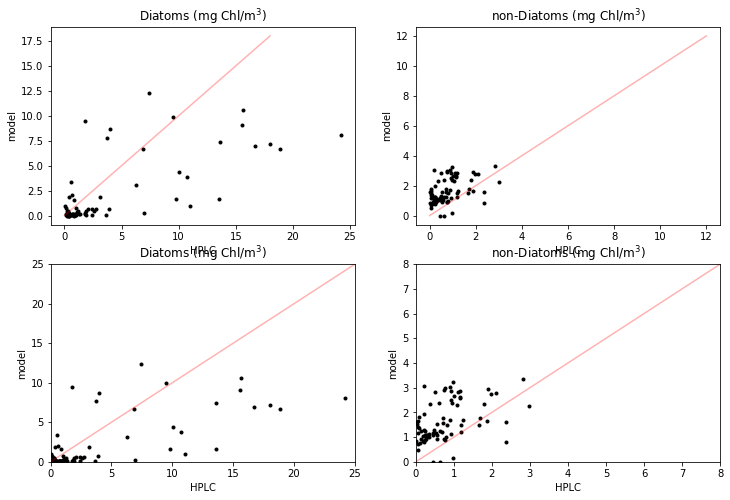

In [8]:
fig,ax=plt.subplots(2,2,figsize=(12,8))
ax=ax.flatten()
ax[0].plot(data['Diatoms-1']+data['Diatoms-2'],Chl_N*data['mod_diatoms'],'k.')
ax[0].set_title('Diatoms (mg Chl/m$^3$)')
ax[0].set_xlabel('HPLC')
ax[0].set_ylabel('model')
ax[0].plot((0,18),(0,18),'r-',alpha=.3)

ax[1].plot(data['other'],Chl_N*(data['mod_flagellates']+data['mod_ciliates']),'k.')
ax[1].set_title('non-Diatoms (mg Chl/m$^3$)')
ax[1].set_xlabel('HPLC')
ax[1].set_ylabel('model')
ax[1].plot((0,12),(0,12),'r-',alpha=.3)

ax[2].plot(data['Diatoms-1']+data['Diatoms-2'],Chl_N*data['mod_diatoms'],'k.')
ax[2].set_title('Diatoms (mg Chl/m$^3$)')
ax[2].set_xlabel('HPLC')
ax[2].set_ylabel('model')
ax[2].plot((0,25),(0,25),'r-',alpha=.3)
ax[2].set_xlim((0,25))
ax[2].set_ylim((0,25))

ax[3].plot(data['other'],Chl_N*(data['mod_flagellates']+data['mod_ciliates']),'k.')
ax[3].set_title('non-Diatoms (mg Chl/m$^3$)')
ax[3].set_xlabel('HPLC')
ax[3].set_ylabel('model')
ax[3].plot((0,12),(0,12),'r-',alpha=.3)
ax[3].set_xlim((0,8))
ax[3].set_ylim((0,8))

In [9]:
def logt(x):
    return np.log10(x+.001)

(-3.1, 2)

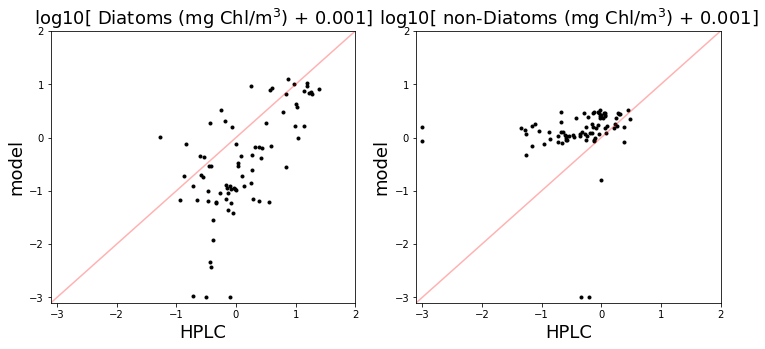

In [10]:
fig,ax=plt.subplots(1,2,figsize=(12,5))
ax[0].plot(logt(data['Diatoms-1']+data['Diatoms-2']),logt(Chl_N*data['mod_diatoms']),'k.')
ax[0].set_title('log10[ Diatoms (mg Chl/m$^3$) + 0.001]',fontsize=18)
ax[0].set_xlabel('HPLC',fontsize=18)
ax[0].set_ylabel('model',fontsize=18)
ax[0].set_xlim(-3.1,2)
ax[0].set_ylim(-3.1,2)
ax[0].plot((-6,3),(-6,3),'r-',alpha=.3)

ax[1].plot(logt(data['other']),logt(Chl_N*(data['mod_flagellates']+data['mod_ciliates'])),'k.')
ax[1].set_title('log10[ non-Diatoms (mg Chl/m$^3$) + 0.001]',fontsize=18)
ax[1].set_xlabel('HPLC',fontsize=18)
ax[1].set_ylabel('model',fontsize=18)
ax[1].plot((-6,3),(-6,3),'r-',alpha=.3)
ax[1].set_xlim(-3.1,2)
ax[1].set_ylim(-3.1,2)

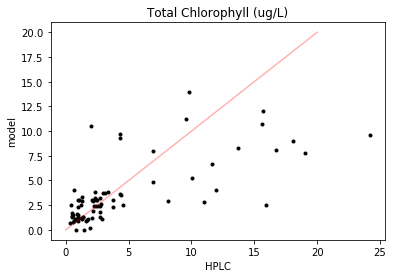

In [11]:
plt.plot(data['TchlA (ug/L)'],Chl_N*(data['mod_flagellates']+data['mod_ciliates']+data['mod_diatoms']),'k.')
plt.title('Total Chlorophyll (ug/L)')
plt.xlabel('HPLC')
plt.ylabel('model')
plt.plot((0,20),(0,20),'r-',alpha=.3)

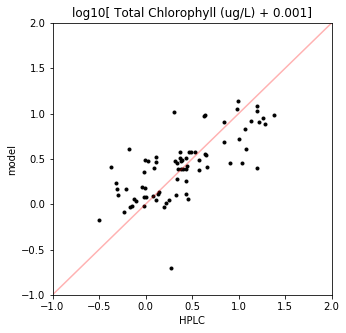

In [12]:
fig,ax=plt.subplots(1,1,figsize=(5,5))
ax.plot(logt(data['TchlA (ug/L)']),logt(Chl_N*(data['mod_flagellates']+data['mod_ciliates']+data['mod_diatoms'])),'k.')
ax.set_title('log10[ Total Chlorophyll (ug/L) + 0.001]')
ax.set_xlabel('HPLC')
ax.set_ylabel('model')
ax.plot((-6,5),(-6,5),'r-',alpha=.3)
ax.set_xlim(-1,2)
ax.set_ylim(-1,2);

In [13]:
def yd(idt):
    if type(idt)==dt.datetime:
        yd=(idt-dt.datetime(idt.year-1,12,31)).days
    else: # assume array or pandas
        yd=[(ii-dt.datetime(ii.year-1,12,31)).days for ii in idt]
    return yd

data['yd']=yd(data['dtUTC'])
data['Year']=[ii.year for ii in data['dtUTC']]

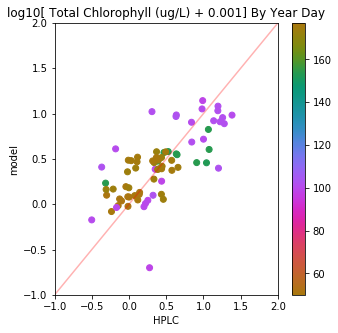

In [14]:
fig,ax=plt.subplots(1,1,figsize=(5,5))
m=ax.scatter(logt(data['TchlA (ug/L)']),logt(Chl_N*(data['mod_flagellates']+data['mod_ciliates']+data['mod_diatoms'])),
          c=data['yd'],cmap=cmocean.cm.phase)
ax.set_title('log10[ Total Chlorophyll (ug/L) + 0.001] By Year Day')
ax.set_xlabel('HPLC')
ax.set_ylabel('model')
ax.plot((-6,5),(-6,5),'r-',alpha=.3)
ax.set_xlim(-1,2)
ax.set_ylim(-1,2);
fig.colorbar(m)

In [15]:
with nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc') as mesh:
    tmask=np.copy(mesh.variables['tmask'][0,:,:,:])
    navlat=np.copy(mesh.variables['nav_lat'][:,:])
    navlon=np.copy(mesh.variables['nav_lon'][:,:])

## Multiple Linear Regression

#### Diatoms

In [16]:
ii=(~pd.isnull(data['mod_diatoms']))&(~pd.isnull(data['Diatoms-1']))&(~pd.isnull(data['Diatoms-2']))&(~pd.isnull(data['Cyanobacteria']))&\
        (~pd.isnull(data['Cryptophytes']))&(~pd.isnull(data['Prasinophytes']))&(~pd.isnull(data['Haptophytes']))&\
        (~pd.isnull(data['Dictyochophytes']))&(~pd.isnull(data['Dinoflagellates']))&(~pd.isnull(data['Raphidophytes']))
A=np.vstack([data.loc[ii]['Diatoms-1'],data.loc[ii]['Diatoms-2'],data.loc[ii]['Cyanobacteria'],data.loc[ii]['Cryptophytes'],
               data.loc[ii]['Prasinophytes'],data.loc[ii]['Haptophytes'],data.loc[ii]['Dictyochophytes'],data.loc[ii]['Dinoflagellates'],
             data.loc[ii]['Raphidophytes'],np.ones(np.shape(data.loc[ii]['Diatoms-1']))]).T
b=data.loc[ii]['mod_diatoms']
m=np.linalg.lstsq(A,b,rcond=None)[0]

In [17]:
m

array([  0.19351624,  -0.77565467, -13.97293706,  -0.48243909,
         0.01652887,   0.95871677,   2.97716958,  -1.32722615,
        -3.02310673,   0.84447802])

In [18]:
clist=('Diatoms-1','Diatoms-2','Cyanobacteria','Cryptophytes','Prasinophytes','Haptophytes',
        'Dictyochophytes','Dinoflagellates','Raphidophytes','ones')
for c, mm in zip(clist,m):
    print(c,mm)

Diatoms-1 0.19351624215050198
Diatoms-2 -0.7756546722245347
Cyanobacteria -13.972937062153331
Cryptophytes -0.4824390853503947
Prasinophytes 0.01652886514431737
Haptophytes 0.9587167733602234
Dictyochophytes 2.977169577025429
Dinoflagellates -1.3272261494046853
Raphidophytes -3.023106728056278
ones 0.8444780211607362


In [19]:
ii=(~pd.isnull(data['mod_diatoms']))&(~pd.isnull(data['Diatoms-1']))&(~pd.isnull(data['Diatoms-2']))&\
        (~pd.isnull(data['Cryptophytes']))&(~pd.isnull(data['Raphidophytes']))
A=np.vstack([data.loc[ii]['Diatoms-1'],data.loc[ii]['Diatoms-2'],data.loc[ii]['Cryptophytes'],
            data.loc[ii]['Raphidophytes'],np.ones(np.shape(data.loc[ii]['Diatoms-1']))]).T
b=data.loc[ii]['mod_diatoms']
m=np.linalg.lstsq(A,b,rcond=None)[0]

In [20]:
clist=('Diatoms-1','Diatoms-2','Cryptophytes','Raphidophytes','ones')
for c, mm in zip(clist,m):
    print(c,mm)

Diatoms-1 0.20720374007506737
Diatoms-2 -0.681543202257153
Cryptophytes -0.9484077001500645
Raphidophytes -2.5454193177848055
ones 0.8471212833120993


In [21]:
ii=(~pd.isnull(data['mod_diatoms']))&(~pd.isnull(data['Diatoms-1']))&\
        (~pd.isnull(data['Cryptophytes']))&(~pd.isnull(data['Raphidophytes']))
A=np.vstack([data.loc[ii]['Diatoms-1'],data.loc[ii]['Cryptophytes'],
            data.loc[ii]['Raphidophytes'],np.ones(np.shape(data.loc[ii]['Diatoms-1']))]).T
b=data.loc[ii]['mod_diatoms']
m=np.linalg.lstsq(A,b,rcond=None)[0]

In [22]:
clist=('Diatoms-1','Cryptophytes','Raphidophytes','ones')
for c, mm in zip(clist,m):
    print(c,mm)

Diatoms-1 0.2083651543067072
Cryptophytes -0.9719077283406659
Raphidophytes -2.257026391982508
ones 0.7373808853324881


#### flagellates

In [23]:
ii=(~pd.isnull(data['mod_flagellates']))&(~pd.isnull(data['Diatoms-1']))&(~pd.isnull(data['Diatoms-2']))&(~pd.isnull(data['Cyanobacteria']))&\
        (~pd.isnull(data['Cryptophytes']))&(~pd.isnull(data['Prasinophytes']))&(~pd.isnull(data['Haptophytes']))&\
        (~pd.isnull(data['Dictyochophytes']))&(~pd.isnull(data['Dinoflagellates']))&(~pd.isnull(data['Raphidophytes']))
A=np.vstack([data.loc[ii]['Diatoms-1'],data.loc[ii]['Diatoms-2'],data.loc[ii]['Cyanobacteria'],data.loc[ii]['Cryptophytes'],
               data.loc[ii]['Prasinophytes'],data.loc[ii]['Haptophytes'],data.loc[ii]['Dictyochophytes'],data.loc[ii]['Dinoflagellates'],
             data.loc[ii]['Raphidophytes'],np.ones(np.shape(data.loc[ii]['Diatoms-1']))]).T
b=data.loc[ii]['mod_flagellates']
m=np.linalg.lstsq(A,b,rcond=None)[0]

In [24]:
m

array([ 0.00886822, -0.21286139,  8.83937039,  0.26895135,  0.49542797,
       -0.0490515 ,  2.37417106,  0.39408627, -0.85740554,  0.29188781])

In [25]:
clist=('Diatoms-1','Diatoms-2','Cyanobacteria','Cryptophytes','Prasinophytes','Haptophytes',
        'Dictyochophytes','Dinoflagellates','Raphidophytes','ones')
for c, mm in zip(clist,m):
    print(c,mm)

Diatoms-1 0.00886822230889089
Diatoms-2 -0.21286138636471635
Cyanobacteria 8.839370391923
Cryptophytes 0.26895135478875143
Prasinophytes 0.4954279657135656
Haptophytes -0.049051499996199135
Dictyochophytes 2.374171056756315
Dinoflagellates 0.3940862723050104
Raphidophytes -0.8574055360964058
ones 0.2918878074941152


In [26]:
ii=(~pd.isnull(data['mod_flagellates']))&(~pd.isnull(data['Diatoms-1']))&(~pd.isnull(data['Cyanobacteria']))&\
        (~pd.isnull(data['Cryptophytes']))&(~pd.isnull(data['Prasinophytes']))&(~pd.isnull(data['Haptophytes']))&\
        (~pd.isnull(data['Dictyochophytes']))&(~pd.isnull(data['Dinoflagellates']))&(~pd.isnull(data['Raphidophytes']))
A=np.vstack([data.loc[ii]['Diatoms-1'],data.loc[ii]['Cyanobacteria'],data.loc[ii]['Cryptophytes'],
               data.loc[ii]['Prasinophytes'],data.loc[ii]['Haptophytes'],data.loc[ii]['Dictyochophytes'],
             data.loc[ii]['Dinoflagellates'],np.ones(np.shape(data.loc[ii]['Diatoms-1']))]).T
b=data.loc[ii]['mod_flagellates']
m=np.linalg.lstsq(A,b,rcond=None)[0]

In [27]:
clist=('Diatoms-1','Cyanobacteria','Cryptophytes','Prasinophytes','Haptophytes',
        'Dictyochophytes','Dinoflagellates','ones')
for c, mm in zip(clist,m):
    print(c,mm)

Diatoms-1 0.009991411362469773
Cyanobacteria 8.849635029261417
Cryptophytes 0.2726775025840442
Prasinophytes 0.30564903335635785
Haptophytes -0.07245010976488331
Dictyochophytes 2.0926428145781455
Dinoflagellates 0.3205712885751423
ones 0.2472687399022515


In [28]:
ii=(~pd.isnull(data['mod_flagellates']))&(~pd.isnull(data['Cyanobacteria']))&\
        (~pd.isnull(data['Cryptophytes']))&(~pd.isnull(data['Prasinophytes']))&(~pd.isnull(data['Haptophytes']))&\
        (~pd.isnull(data['Dictyochophytes']))&(~pd.isnull(data['Raphidophytes']))
A=np.vstack([data.loc[ii]['Cyanobacteria'],data.loc[ii]['Cryptophytes'],
               data.loc[ii]['Prasinophytes'],data.loc[ii]['Haptophytes'],data.loc[ii]['Dictyochophytes'],
             np.ones(np.shape(data.loc[ii]['Diatoms-1']))]).T
b=data.loc[ii]['mod_flagellates']
m=np.linalg.lstsq(A,b,rcond=None)[0]

In [29]:
clist=('Cyanobacteria','Cryptophytes','Prasinophytes','Haptophytes',
        'Dictyochophytes','ones')
for c, mm in zip(clist,m):
    print(c,mm)

Cyanobacteria 8.165457620016463
Cryptophytes 0.3285546004473828
Prasinophytes 0.19550923716456112
Haptophytes -0.02165695345381155
Dictyochophytes 2.8790268218676207
ones 0.2985904573017174


#### M. rubrum

In [30]:
ii=(~pd.isnull(data['mod_ciliates']))&(~pd.isnull(data['Diatoms-1']))&(~pd.isnull(data['Diatoms-2']))&(~pd.isnull(data['Cyanobacteria']))&\
        (~pd.isnull(data['Cryptophytes']))&(~pd.isnull(data['Prasinophytes']))&(~pd.isnull(data['Haptophytes']))&\
        (~pd.isnull(data['Dictyochophytes']))&(~pd.isnull(data['Dinoflagellates']))&(~pd.isnull(data['Raphidophytes']))
A=np.vstack([data.loc[ii]['Diatoms-1'],data.loc[ii]['Diatoms-2'],data.loc[ii]['Cyanobacteria'],data.loc[ii]['Cryptophytes'],
               data.loc[ii]['Prasinophytes'],data.loc[ii]['Haptophytes'],data.loc[ii]['Dictyochophytes'],data.loc[ii]['Dinoflagellates'],
             data.loc[ii]['Raphidophytes'],np.ones(np.shape(data.loc[ii]['Diatoms-1']))]).T
b=data.loc[ii]['mod_ciliates']
m=np.linalg.lstsq(A,b,rcond=None)[0]

In [31]:
clist=('Diatoms-1','Diatoms-2','Cyanobacteria','Cryptophytes','Prasinophytes','Haptophytes',
        'Dictyochophytes','Dinoflagellates','Raphidophytes','ones')
for c, mm in zip(clist,m):
    print(c,mm)

Diatoms-1 0.00948088688129159
Diatoms-2 -0.08685983436028455
Cyanobacteria 1.5199145871811364
Cryptophytes 0.20741928688995184
Prasinophytes -0.019662842402396734
Haptophytes -0.007767124963180806
Dictyochophytes -0.2744810226796523
Dinoflagellates 0.003971941684653393
Raphidophytes 0.08896177908124361
ones 0.2938983299963624


Diatoms:
- Cryptophytes 0.38
- Diatoms-1 0.16
- Raphidophytes 0.09

Flagellates:
- Cyanobacteria 0.9248939785743201
- Cryptophytes 0.592769155988474
- Prasinophytes 0.18975008147644779
- Haptophytes 0.2794204846195845
- Dictyochophytes 0.058845777018170356

M. rubrum:
- Cyanobacteria 0.2710109702166438

None:
- Diatoms-2
- Dinoflagellates

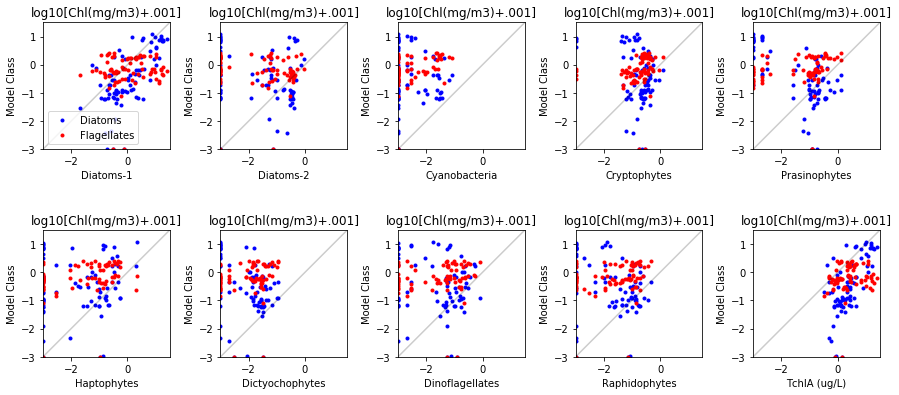

In [32]:
fig,ax=plt.subplots(2,5,figsize=(15,7))
fig.subplots_adjust(wspace=.4)
ax=ax.flatten()

chplc=('Diatoms-1', 'Diatoms-2','Cyanobacteria','Cryptophytes', 'Prasinophytes', 
       'Haptophytes',  'Dictyochophytes','Dinoflagellates','Raphidophytes','TchlA (ug/L)')

mvar1=Chl_N*data['mod_diatoms']
mvar2=Chl_N*data['mod_flagellates']

for ii in range(0,len(chplc)):
    ax[ii].plot(logt(data.loc[:,[chplc[ii]]].values),logt(mvar1),'.',color='blue',label='Diatoms')
    ax[ii].plot(logt(data.loc[:,[chplc[ii]]].values),logt(mvar2),'.',color='red',label='Flagellates')
    ax[ii].set_ylabel('Model Class')
    ax[ii].set_xlabel(chplc[ii])
    ax[ii].set_title('log10[Chl(mg/m3)+.001]')
    ax[ii].plot((-3,1.5),(-3,1.5),'k-',alpha=.2)
    ax[ii].set_xlim((-3,1.5))
    ax[ii].set_ylim((-3,1.5))
    ax[ii].set_aspect(1)
ax[0].legend()


(-3, 1.5)

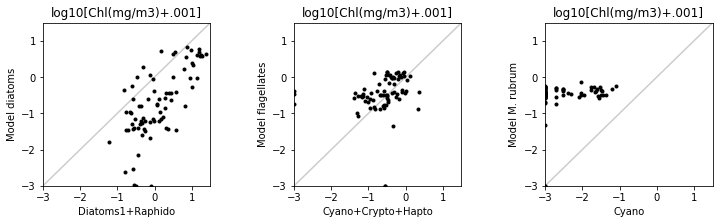

In [33]:
fig,ax=plt.subplots(1,3,figsize=(12,3))
fig.subplots_adjust(wspace=.5)
#ax[0].plot(logt(data['Diatoms-1']+data['Raphidophytes']+.5*data['Cryptophytes']),logt(data['mod_diatoms']),'r.')
ax[0].plot(logt(data['Diatoms-1']+data['Raphidophytes']),logt(data['mod_diatoms']),'k.')
ax[0].set_ylabel('Model diatoms')
ax[0].set_xlabel('Diatoms1+Raphido')
ax[0].set_title('log10[Chl(mg/m3)+.001]')
ax[0].plot((-3,1.5),(-3,1.5),'k-',alpha=.2)
ax[0].set_xlim((-3,1.5))
ax[0].set_ylim((-3,1.5))

ax[1].plot(logt(data['Cyanobacteria']+data['Cryptophytes']+data['Haptophytes']),logt(data['mod_flagellates']),'k.')
ax[1].set_ylabel('Model flagellates')
ax[1].set_xlabel('Cyano+Crypto+Hapto')
ax[1].set_title('log10[Chl(mg/m3)+.001]')
ax[1].plot((-3,1.5),(-3,1.5),'k-',alpha=.2)
ax[1].set_xlim((-3,1.5))
ax[1].set_ylim((-3,1.5))


ax[2].plot(logt(data['Cyanobacteria']),logt(data['mod_ciliates']),'k.')
ax[2].set_ylabel('Model M. rubrum')
ax[2].set_xlabel('Cyano')
ax[2].set_title('log10[Chl(mg/m3)+.001]')
ax[2].plot((-3,1.5),(-3,1.5),'k-',alpha=.2)
ax[2].set_xlim((-3,1.5))
ax[2].set_ylim((-3,1.5))

In [34]:
data['mod_diatoms_chl']=Chl_N*data['mod_diatoms']
data['mod_flagellates_chl']=Chl_N*data['mod_flagellates']
data['mod_ciliates_chl']=Chl_N*data['mod_ciliates']
data['mod_TChl']=data['mod_diatoms_chl']+data['mod_flagellates_chl']+data['mod_ciliates_chl']
data['CCPH']=data['Cyanobacteria']+data['Cryptophytes']+data['Prasinophytes']+data['Haptophytes']
data['DD']=data['Diatoms-1']+data['Diatoms-2']
dfVars=data.loc[:,['Diatoms-1', 'Diatoms-2','Cyanobacteria','Cryptophytes', 'Prasinophytes', 
       'Haptophytes',  'Dictyochophytes','Dinoflagellates','Raphidophytes','DD','CCPH','TchlA (ug/L)',
                   'mod_diatoms_chl','mod_flagellates_chl','mod_ciliates_chl','mod_TChl']]

### Variance-Covariance Matrix

In [35]:
dfVars.cov()

,Diatoms-1,Diatoms-2,Cyanobacteria,Cryptophytes,Prasinophytes,Haptophytes,Dictyochophytes,Dinoflagellates,Raphidophytes,DD,CCPH,TchlA (ug/L),mod_diatoms_chl,mod_flagellates_chl,mod_ciliates_chl,mod_TChl
Diatoms-1,28.980339,0.000725,-0.011834,-0.355219,-0.425118,0.333077,-0.047985,-0.118346,-0.147368,28.981063,-0.459094,28.208197,12.089422,-0.368011,0.339109,12.060520
Diatoms-2,0.000725,0.035508,-0.000647,-0.001112,-0.002439,-0.002373,-0.000318,0.002422,-0.002740,0.036233,-0.006570,0.029008,-0.028837,-0.021798,-0.007869,-0.058504
Cyanobacteria,-0.011834,-0.000647,0.000215,0.000761,0.001725,0.001224,0.000120,-0.000062,0.000620,-0.012480,0.003925,-0.007878,-0.009703,0.004790,0.000733,-0.004180
Cryptophytes,-0.355219,-0.001112,0.000761,0.042844,0.022165,0.002549,0.002220,0.015148,0.007549,-0.356331,0.068319,-0.263110,-0.238849,0.055731,0.011591,-0.171527
Prasinophytes,-0.425118,-0.002439,0.001725,0.022165,0.062551,0.006778,0.004266,0.003478,0.016774,-0.427557,0.093219,-0.309845,-0.270485,0.082317,0.004416,-0.183751
Haptophytes,0.333077,-0.002373,0.001224,0.002549,0.006778,0.121719,0.000633,0.005962,0.005668,0.330705,0.132270,0.475223,0.254895,0.020419,0.009051,0.284365
Dictyochophytes,-0.047985,-0.000318,0.000120,0.002220,0.004266,0.000633,0.000596,0.001722,0.001435,-0.048303,0.007238,-0.037314,-0.028729,0.007639,0.000176,-0.020915
Dinoflagellates,-0.118346,0.002422,-0.000062,0.015148,0.003478,0.005962,0.001722,0.018806,0.002599,-0.115923,0.024526,-0.068282,-0.095662,0.022801,0.002582,-0.070280
Raphidophytes,-0.147368,-0.002740,0.000620,0.007549,0.016774,0.005668,0.001435,0.002599,0.007684,-0.150108,0.030611,-0.107783,-0.099697,0.022786,0.002294,-0.074617
DD,28.981063,0.036233,-0.012480,-0.356331,-0.427557,0.330705,-0.048303,-0.115923,-0.150108,29.017296,-0.465664,28.237206,12.060585,-0.389808,0.331240,12.002017


### Correlation Coefficient Matrix

In [36]:
dfVars.corr()

,Diatoms-1,Diatoms-2,Cyanobacteria,Cryptophytes,Prasinophytes,Haptophytes,Dictyochophytes,Dinoflagellates,Raphidophytes,DD,CCPH,TchlA (ug/L),mod_diatoms_chl,mod_flagellates_chl,mod_ciliates_chl,mod_TChl
Diatoms-1,1.000000,0.000714,-0.149948,-0.318788,-0.315748,0.177343,-0.365245,-0.160305,-0.312282,0.999388,-0.156292,0.991702,0.709344,-0.092857,0.282530,0.706840
Diatoms-2,0.000714,1.000000,-0.234117,-0.028506,-0.051756,-0.036088,-0.069095,0.093739,-0.165887,0.035695,-0.063900,0.029135,-0.048339,-0.157129,-0.187290,-0.097955
Cyanobacteria,-0.149948,-0.234117,1.000000,0.250910,0.470519,0.239314,0.335389,-0.030621,0.482105,-0.158042,0.490727,-0.101703,-0.209067,0.443839,0.224166,-0.089967
Cryptophytes,-0.318788,-0.028506,0.250910,1.000000,0.428161,0.035300,0.439402,0.533641,0.416060,-0.319582,0.604902,-0.240576,-0.364489,0.365730,0.251163,-0.261455
Prasinophytes,-0.315748,-0.051756,0.470519,0.428161,1.000000,0.077677,0.698855,0.101412,0.765112,-0.317358,0.683082,-0.234468,-0.341609,0.447074,0.079200,-0.231804
Haptophytes,0.177343,-0.036088,0.239314,0.035300,0.077677,1.000000,0.074382,0.124604,0.185330,0.175967,0.694814,0.257795,0.230773,0.079501,0.116359,0.257160
Dictyochophytes,-0.365245,-0.069095,0.335389,0.439402,0.698855,0.074382,1.000000,0.514586,0.670920,-0.367429,0.543577,-0.289376,-0.371845,0.425185,0.032314,-0.270387
Dinoflagellates,-0.160305,0.093739,-0.030621,0.533641,0.101412,0.124604,0.514586,1.000000,0.216205,-0.156924,0.327762,-0.094235,-0.220339,0.225841,0.084446,-0.161690
Raphidophytes,-0.312282,-0.165887,0.482105,0.416060,0.765112,0.185330,0.670920,0.216205,1.000000,-0.317886,0.639973,-0.232705,-0.359237,0.353076,0.117373,-0.268560
DD,0.999388,0.035695,-0.158042,-0.319582,-0.317358,0.175967,-0.367429,-0.156924,-0.317886,1.000000,-0.158428,0.992089,0.707201,-0.098294,0.275798,0.702963


### Cov matrix with log transformed values:

In [37]:
dflog=pd.DataFrame()
for el in ['Diatoms-1', 'Diatoms-2','Cyanobacteria','Cryptophytes', 'Prasinophytes', 
       'Haptophytes',  'Dictyochophytes','Dinoflagellates','Raphidophytes','CCPH','TchlA (ug/L)',
                   'mod_diatoms_chl','mod_flagellates_chl','mod_ciliates_chl','mod_TChl']:
    dflog[el]=logt(data[el])
dflog.cov()

,Diatoms-1,Diatoms-2,Cyanobacteria,Cryptophytes,Prasinophytes,Haptophytes,Dictyochophytes,Dinoflagellates,Raphidophytes,CCPH,TchlA (ug/L),mod_diatoms_chl,mod_flagellates_chl,mod_ciliates_chl,mod_TChl
Diatoms-1,0.499638,-0.196203,-0.052984,-0.164701,-0.413351,0.048845,-0.237909,-0.098421,-0.296364,-0.151862,0.296918,0.452866,0.036078,0.055502,0.197078
Diatoms-2,-0.196203,1.218432,-0.151914,0.077418,0.218363,-0.156461,0.107656,0.233686,-0.009668,0.113267,-0.135764,-0.189529,-0.078266,-0.009464,-0.124996
Cyanobacteria,-0.052984,-0.151914,0.363382,0.110137,0.184474,0.243283,0.129029,-0.001152,0.279141,0.156652,-0.010807,-0.011901,0.116947,0.049208,0.051036
Cryptophytes,-0.164701,0.077418,0.110137,0.365233,0.382114,0.239490,0.208582,0.238058,0.304807,0.347046,-0.086782,-0.197257,0.056782,-0.010848,-0.083342
Prasinophytes,-0.413351,0.218363,0.184474,0.382114,1.028052,0.281131,0.490563,0.384218,0.592364,0.423511,-0.190982,-0.636819,0.108291,-0.051378,-0.232235
Haptophytes,0.048845,-0.156461,0.243283,0.239490,0.281131,1.197202,0.076221,0.234966,0.284341,0.431452,0.111981,0.074946,0.168971,0.044857,0.104381
Dictyochophytes,-0.237909,0.107656,0.129029,0.208582,0.490563,0.076221,0.468250,0.247732,0.424464,0.216706,-0.101941,-0.262538,0.080421,-0.011466,-0.097984
Dinoflagellates,-0.098421,0.233686,-0.001152,0.238058,0.384218,0.234966,0.247732,0.860910,0.258878,0.266540,-0.013282,-0.146188,0.030643,-0.027937,-0.112980
Raphidophytes,-0.296364,-0.009668,0.279141,0.304807,0.592364,0.284341,0.424464,0.258878,0.789524,0.366785,-0.123373,-0.289627,0.094310,0.023895,-0.085894
CCPH,-0.151862,0.113267,0.156652,0.347046,0.423511,0.431452,0.216706,0.266540,0.366785,0.430558,-0.060245,-0.198449,0.072657,-0.007228,-0.069200


### Corr Coeff matrix with log transformed values:

In [38]:
dflog.corr()

,Diatoms-1,Diatoms-2,Cyanobacteria,Cryptophytes,Prasinophytes,Haptophytes,Dictyochophytes,Dinoflagellates,Raphidophytes,CCPH,TchlA (ug/L),mod_diatoms_chl,mod_flagellates_chl,mod_ciliates_chl,mod_TChl
Diatoms-1,1.000000,-0.251465,-0.124347,-0.385553,-0.576745,0.063155,-0.491864,-0.150066,-0.471863,-0.327420,0.905948,0.655014,0.089671,0.165728,0.430756
Diatoms-2,-0.251465,1.000000,-0.228305,0.116052,0.195106,-0.129545,0.142528,0.228167,-0.009857,0.156382,-0.265264,-0.175543,-0.124570,-0.018096,-0.174950
Cyanobacteria,-0.124347,-0.228305,1.000000,0.302320,0.301818,0.368847,0.312799,-0.002060,0.521146,0.396039,-0.038666,-0.020184,0.340837,0.172292,0.130801
Cryptophytes,-0.385553,0.116052,0.302320,1.000000,0.623592,0.362176,0.504375,0.424541,0.567619,0.875157,-0.309699,-0.333700,0.165069,-0.037885,-0.213059
Prasinophytes,-0.576745,0.195106,0.301818,0.623592,1.000000,0.253406,0.707048,0.408405,0.657504,0.636563,-0.406236,-0.642122,0.187641,-0.106949,-0.353868
Haptophytes,0.063155,-0.129545,0.368847,0.362176,0.253406,1.000000,0.101801,0.231442,0.292465,0.600943,0.220727,0.070028,0.271313,0.086528,0.147386
Dictyochophytes,-0.491864,0.142528,0.312799,0.504375,0.707048,0.101801,1.000000,0.390180,0.698104,0.482632,-0.321294,-0.392249,0.206478,-0.035366,-0.221226
Dinoflagellates,-0.150066,0.228167,-0.002060,0.424541,0.408405,0.231442,0.390180,1.000000,0.314003,0.437792,-0.030873,-0.161080,0.058022,-0.063550,-0.188124
Raphidophytes,-0.471863,-0.009857,0.521146,0.567619,0.657504,0.292465,0.698104,0.314003,1.000000,0.629091,-0.299455,-0.333247,0.186473,0.056760,-0.149348
CCPH,-0.327420,0.156382,0.396039,0.875157,0.636563,0.600943,0.482632,0.437792,0.629091,1.000000,-0.198014,-0.309201,0.194537,-0.023248,-0.162934


### New groups Model-Obs Comparison:

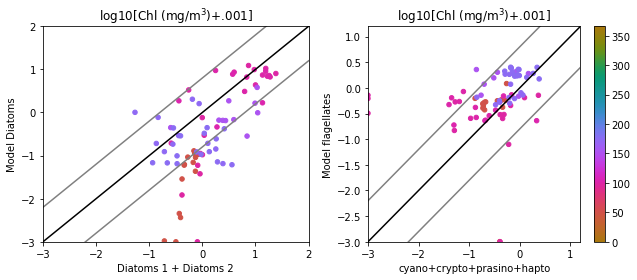

In [39]:
thresh=.8
msize=20
fig,ax=plt.subplots(1,2,figsize=(9,4))
m=ax[0].scatter(logt(data['DD']),logt(data['mod_diatoms_chl']),
          c=data['yd'],s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
m=ax[1].scatter(logt(data['CCPH']),logt(data['mod_flagellates_chl']),
          c=data['yd'],s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
ax[0].set_xlim(-3,2)
ax[0].set_ylim(-3,2)
ax[1].set_xlim(-3,1.2)
ax[1].set_ylim(-3,1.2)
ax[0].set_xlabel('Diatoms 1 + Diatoms 2')
ax[0].set_ylabel('Model Diatoms')
ax[0].set_title('log10[Chl (mg/m$^3$)+.001]')
ax[1].set_xlabel('cyano+crypto+prasino+hapto')
ax[1].set_ylabel('Model flagellates')
ax[1].set_title('log10[Chl (mg/m$^3$)+.001]')
ax[0].plot((-3,2),(-3+thresh,2+thresh),'-',color='grey')
ax[0].plot((-3,2),(-3-thresh,2-thresh),'-',color='grey')
ax[1].plot((-3,2),(-3+thresh,2+thresh),'-',color='grey')
ax[1].plot((-3,2),(-3-thresh,2-thresh),'-',color='grey')
ax[0].plot((-3,2),(-3,2),'k-')
ax[1].plot((-3,1.2),(-3,1.2),'k-')
plt.tight_layout()
fig.colorbar(m,ax=ax[1])

Diatoms/DD


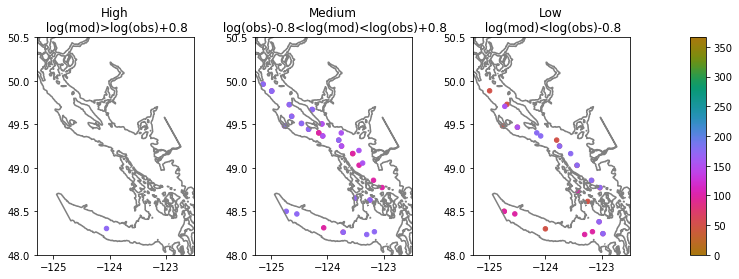

In [40]:
print('Diatoms/DD')
fig,ax=plt.subplots(1,4,figsize=(12,4),gridspec_kw={'width_ratios': [1,1,1,.1],'wspace':.5},)
for iax in ax[0:3]:
    iax.contour(navlon,navlat,tmask[0,:,:],levels=[0.5,],colors='gray')
    iax.set_xlim(-125.3,-122.5)
    iax.set_ylim(48,50.5)
ihi=logt(data['mod_diatoms_chl'])>(logt(data['DD'])+thresh)
ilo=logt(data['mod_diatoms_chl'])<(logt(data['DD'])-thresh)
idata=data.loc[(data.DD>=0)&ihi]
ax[0].scatter(idata.Lon,idata.Lat,c=idata.yd,s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
ax[0].set_title('High\n log(mod)>log(obs)+'+str(thresh))
idata=data.loc[(data.DD>=0)&(~ihi)&(~ilo)]
ax[1].scatter(idata.Lon,idata.Lat,c=idata.yd,s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
ax[1].set_title('Medium\n log(obs)-'+str(thresh)+'<log(mod)<log(obs)+'+str(thresh))
idata=data.loc[(data.DD>=0)&ilo]
m=ax[2].scatter(idata.Lon,idata.Lat,c=idata.yd,s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
ax[2].set_title('Low\n log(mod)<log(obs)-'+str(thresh));
fig.colorbar(m,cax=ax[3]);

Flagellates/CCPH


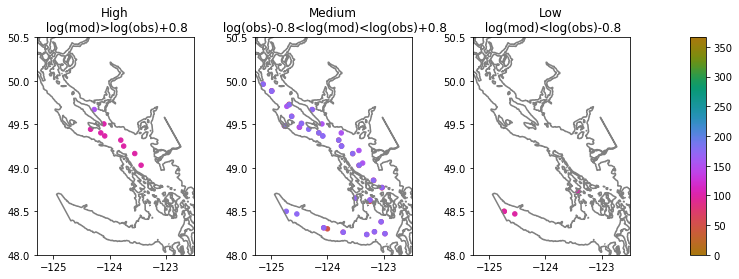

In [41]:
print('Flagellates/CCPH')
fig,ax=plt.subplots(1,4,figsize=(12,4),gridspec_kw={'width_ratios': [1,1,1,.1],'wspace':.5},)
for iax in ax[0:3]:
    iax.contour(navlon,navlat,tmask[0,:,:],levels=[0.5,],colors='gray')
    iax.set_xlim(-125.3,-122.5)
    iax.set_ylim(48,50.5)
ihi=logt(data['mod_flagellates_chl'])>(logt(data['CCPH'])+thresh)
ilo=logt(data['mod_flagellates_chl'])<(logt(data['CCPH'])-thresh)
idata=data.loc[(data.CCPH>=0)&ihi]
ax[0].scatter(idata.Lon,idata.Lat,c=idata.yd,s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
ax[0].set_title('High\n log(mod)>log(obs)+'+str(thresh))
idata=data.loc[(data.CCPH>=0)&(~ihi)&(~ilo)]
ax[1].scatter(idata.Lon,idata.Lat,c=idata.yd,s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
ax[1].set_title('Medium\n log(obs)-'+str(thresh)+'<log(mod)<log(obs)+'+str(thresh))
idata=data.loc[(data.CCPH>=0)&ilo]
m=ax[2].scatter(idata.Lon,idata.Lat,c=idata.yd,s=msize,cmap=cmocean.cm.phase,vmin=0,vmax=366)
ax[2].set_title('Low\n log(mod)<log(obs)-'+str(thresh));
fig.colorbar(m,cax=ax[3]);

### Diatom fraction

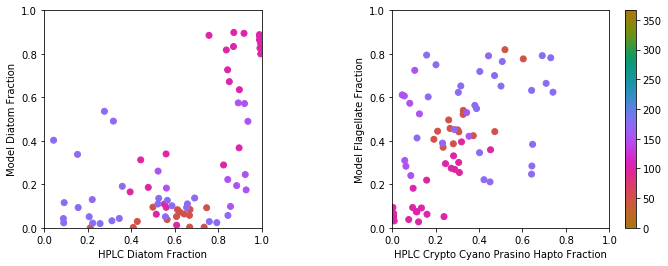

In [42]:
fig,ax=plt.subplots(1,2,figsize=(12,4))
diatFracMod=data['mod_diatoms']/(data['mod_diatoms']+data['mod_flagellates']+data['mod_ciliates'])
diatFracObs=data['DD']/data['TchlA (ug/L)']
m=ax[0].scatter(diatFracObs,diatFracMod,
          c=data['yd'],cmap=cmocean.cm.phase,vmin=0,vmax=366,)
ax[0].set_xlabel('HPLC Diatom Fraction')
ax[0].set_ylabel('Model Diatom Fraction')
ax[0].set_xlim((0,1))
ax[0].set_ylim((0,1))
flFracMod=data['mod_flagellates']/(data['mod_diatoms']+data['mod_flagellates']+data['mod_ciliates'])
CCPHFracObs=data['CCPH']/data['TchlA (ug/L)']
m=ax[1].scatter(CCPHFracObs,flFracMod,
          c=data['yd'],cmap=cmocean.cm.phase,vmin=0,vmax=366,)
ax[1].set_xlabel('HPLC Crypto Cyano Prasino Hapto Fraction')
ax[1].set_ylabel('Model Flagellate Fraction')
ax[1].set_xlim((0,1))
ax[1].set_ylim((0,1))
ax[0].set_aspect(1)
ax[1].set_aspect(1)

fig.colorbar(m)

In [43]:
#Reminder:
np.random.seed(42)
df = pd.DataFrame(np.random.randn(1000, 4),columns=['a', 'b', 'c','d'])
df['a+b+c']=.2*df['a']+.3*df['b']+.45*df['c']

In [44]:
df.cov()

,a,b,c,d,a+b+c
a,0.929140,0.007946,-0.037053,-0.022301,0.171538
b,0.007946,1.023910,-0.032939,0.004689,0.293940
c,-0.037053,-0.032939,1.012188,0.034186,0.438192
d,-0.022301,0.004689,0.034186,1.013977,0.012330
a+b+c,0.171538,0.293940,0.438192,0.012330,0.319676


In [45]:
df.corr()

,a,b,c,d,a+b+c
a,1.000000,0.008146,-0.038208,-0.022976,0.314749
b,0.008146,1.000000,-0.032355,0.004602,0.513774
c,-0.038208,-0.032355,1.000000,0.033745,0.770334
d,-0.022976,0.004602,0.033745,1.000000,0.021657
a+b+c,0.314749,0.513774,0.770334,0.021657,1.000000


In [46]:
A=np.vstack([df['a'],df['b'],df['c'],df['d'],np.ones(np.shape(df['a']))]).T
b=df['a+b+c']
m=np.linalg.lstsq(A,b,rcond=None)[0]
print(m)

[ 2.00000000e-01  3.00000000e-01  4.50000000e-01  1.52655666e-16
 -1.04083409e-16]
